In [ ]:
import os
import pickle
import datetime
import contextily
import geoplot
import pygeoda
import scipy
import geopandas as gpd
import pandas as pd
import numpy as np

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import lines
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pysal.explore import esda
from pysal.lib import weights
from shapely import Polygon
from shapely import Point

In [ ]:
###  recall predicted dataset
data = pd.read_pickle(f"/content/drive/MyDrive/grids_predictions.pkl")
data['year'] = data['time'].apply(lambda x: x.year)

In [ ]:
## Daily Mean SO2
print("Mean: " + str(data["mean_so2"].mean()))
print("Median: " + str(data["mean_so2"].median()))
print("90-th Percentile: " + str(np.percentile(data["mean_so2"], 90)))
print("Std. dev.: " + str(data["mean_so2"].std()))
print("Skewness: " + str(scipy.stats.skew(data["mean_so2"])))

Mean: 0.21607062726700108
Median: 0.17175605327910354
90-th Percentile: 0.42493993222374854
Std. dev.: 0.1961991894149704
Skewness: 7.845195143009944


In [ ]:
## Daily Max SO2
print("Mean: " + str(data["max_so2"].mean()))
print("Median: " + str(data["max_so2"].median()))
print("90-th Percentile: " + str(np.percentile(data["max_so2"], 90)))
print("Std. dev.: " + str(data["max_so2"].std()))
print("Skewness: " + str(scipy.stats.skew(data["max_so2"])))

Mean: 0.7972148779094859
Median: 0.581558250541095
90-th Percentile: 1.663613433781208
Std. dev.: 0.7989435929335043
Skewness: 4.374275019288708


In [ ]:
#  exceedance days with respect to WHO Guideline - 24 hour standard (active before 2021)
print(
  (len(sorted(data[(data['mean_so2']>7.5) & (data['year'] == 2022)]['time'].drop_duplicates())),
   len(sorted(data[(data['mean_so2']>7.5) & (data['year'] == 2023)]['time'].drop_duplicates()))
  )
)

(12, 34)


In [ ]:
#  exceedance days with respect to WHO Guideline - 24 hour standard (active since 2021)
print(
  (len(sorted(data[(data['mean_so2']>15) & (data['year'] == 2022)]['time'].drop_duplicates())),
   len(sorted(data[(data['mean_so2']>15) & (data['year'] == 2023)]['time'].drop_duplicates()))
  )
)

(0, 0)


In [ ]:
#  exceedance days with respect to WHO Guideline - 24 hour standard (active since 2021)
print(
  (len(sorted(data[(data['max_so']>56) & (data['year'] == 2022)]['time'].drop_duplicates())),
   len(sorted(data[(data['max_so2']>56) & (data['year'] == 2023)]['time'].drop_duplicates()))
  )
)

(0, 0)


In [ ]:
def polys_critic(i):
    if i.type == "MultiPolygon":
        return [Polygon(x.exterior.coords) for x in i.geoms]
    else:
        return [Polygon(i.exterior.coords)]

In [ ]:
###  census subdivision of Saint John
os.chdir(f"/content/drive/MyDrive/Shapefiles")
csd_shp = gpd.read_file(f"./Subdivision/lcsd000b21a_e.shp")
csd_sj = csd_shp[csd_shp["CSDNAME"] == "Saint John"]
csd_sj_geom = csd_sj["geometry"].apply(lambda i: polys_critic(i)).explode()
csd_sj_geom_gjs = gpd.GeoDataFrame(csd_sj_geom)
csd_sj_geom_gjs = csd_sj_geom_gjs.set_crs(epsg=3347)
csd_sj_geom_gjs = csd_sj_geom_gjs.to_crs(epsg=4326)

In [ ]:
###  call new brunswick air quality monitoring station data
nb_stations = pd.read_excel(f"/src/NB_Air_Quality_stations_metadata.xlsx")

nb_stations = nb_stations[(nb_stations['city'].isin(['Saint John','Colson Cove'])) & (nb_stations['measurements'].isin(["SO2","TRS"]))]
nb_stations = nb_stations[~((nb_stations['station_name'] == "Forest Hills") & (nb_stations['owner'] == "Government of New Brunswick"))]
nb_stations = nb_stations[nb_stations['station_name'] != "Musquash"]
nb_stations = nb_stations[nb_stations['station_name'] != "Milford"]
nb_stations = nb_stations[nb_stations['station_name'] != "Saint John Street"]

nb_stations['geometry'] = list(zip(nb_stations['longitude'], nb_stations['latitude']))
nb_stations['geometry'] = nb_stations['geometry'].apply(Point)
nb_stations = gpd.GeoDataFrame(nb_stations, geometry='geometry', crs = 'epsg:4326')

In [ ]:
###  extract residential areas and populations

#  spatial raster features
grid_raster = gpd.read_file(f'/content/drive/MyDrive/spatial_features.shp')

grid_raster.columns = [
    'id', 'dem_mean', 'dem_std', 'bh_mean', 'bh_std', 'pop_den_mean', 'pop_den_std',
    'water', 'evergreen_needleleaf_vegetation', 'evergree_broadleaf_vegetation',
    'deciduous_needleleaf_vegetation', 'deciduou_broadleaf_vegetation', 'grass', 'urban', 'geometry'
]

#  spatial vector features
grid_vector = gpd.read_file(f'/content/drive/MyDrive/spatial_vector_features.shp')

grid_vector.columns = [
    'id', 'bus_stop_count', 'bus_route_count', 'bus_route_length', 'railroad_count', 'railroad_length', 'trail_count', 'trail_length',
    'zone_commercial', 'zone_community_facility', 'zone_industrial', 'zone_others', 'zone_residential',
    'osm_road_length_motorway', 'osm_road_length_primary',
    'osm_road_length_secondary', 'osm_road_length_tertiary',
    'osm_road_length_trunk',
    'osm_lanes_motorway', 'osm_lanes_primary',
    'osm_lanes_secondary', 'osm_lanes_tertiary',
    'osm_lanes_trunk',
    'maxpseed_motorway', 'maxpseed_primary',
    'maxpseed_secondary', 'maxpseed_tertiary',
    'maxpseed_trunk',
    'geometry'
]

urban1 = grid_raster[["id","geometry","pop_den_mean","urban"]]
urban2 = grid_vector[["id","geometry","zone_residential","zone_community_facility"]]
urban = urban1.merge(urban2, on=["id","geometry"], how="left")
urban = urban[urban["pop_den_mean"] > 0]
urban = urban.reset_index(drop=True)

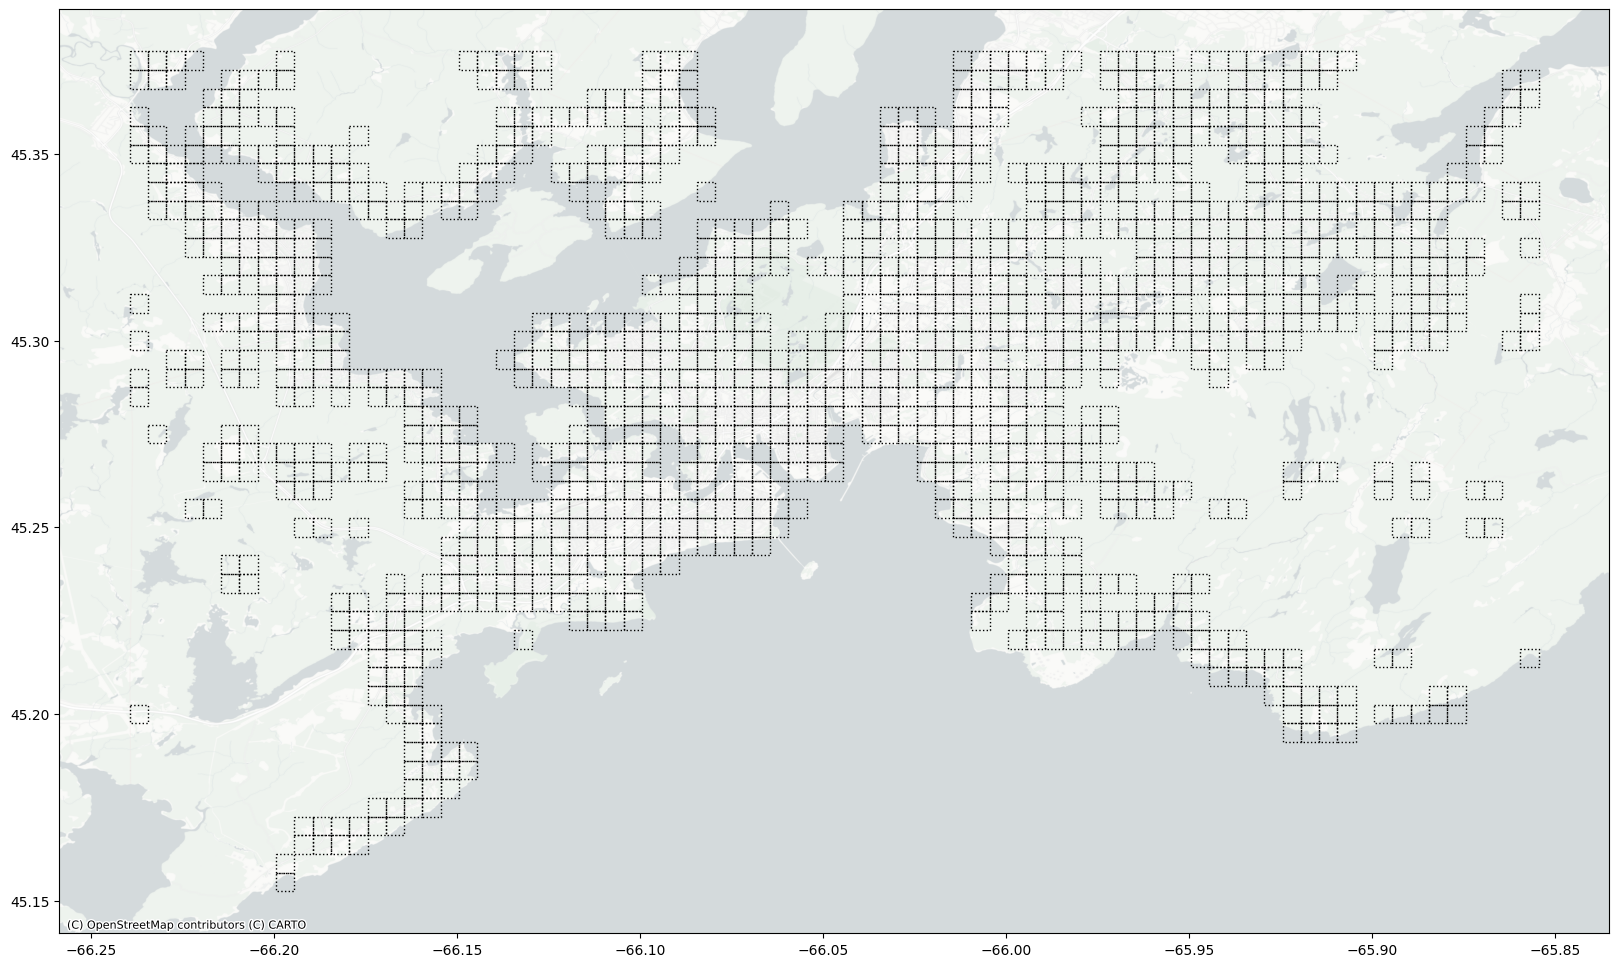

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

urban.plot(ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=1, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    zoom=14
)

####  **Annual Average of HGBM model-derived Daily Mean & Maximum SO2 :**

In [ ]:
annual_data = data.groupby(['id','geometry','year']).agg({"mean_so2_transform": np.mean, "max_so2_transform": np.mean}).reset_index()
annual_data_2022 = annual_data[annual_data['year'] == 2022]
annual_data_2023 = annual_data[annual_data['year'] == 2023]
annual_data_2022 = annual_data_2022.drop(['year'], axis=1)
annual_data_2023 = annual_data_2023.drop(['year'], axis=1)

In [ ]:
# Rook weights
w2022 = weights.Rook.from_dataframe(annual_data_2022)
w2023 = weights.Rook.from_dataframe(annual_data_2023)

In [ ]:
# Gi* statistic
gi_star_2022_mean = esda.getisord.G_Local(annual_data_2022["mean_so2_transform"], w2022, star=True, transform='R', permutations=1000, seed=123)
gi_star_2023_mean = esda.getisord.G_Local(annual_data_2023["mean_so2_transform"], w2023, star=True, transform='R', permutations=1000, seed=123)
gi_star_2022_max = esda.getisord.G_Local(annual_data_2022["max_so2_transform"], w2022, star=True, transform='R', permutations=1000, seed=123)
gi_star_2023_max = esda.getisord.G_Local(annual_data_2023["max_so2_transform"], w2023, star=True, transform='R', permutations=1000, seed=123)

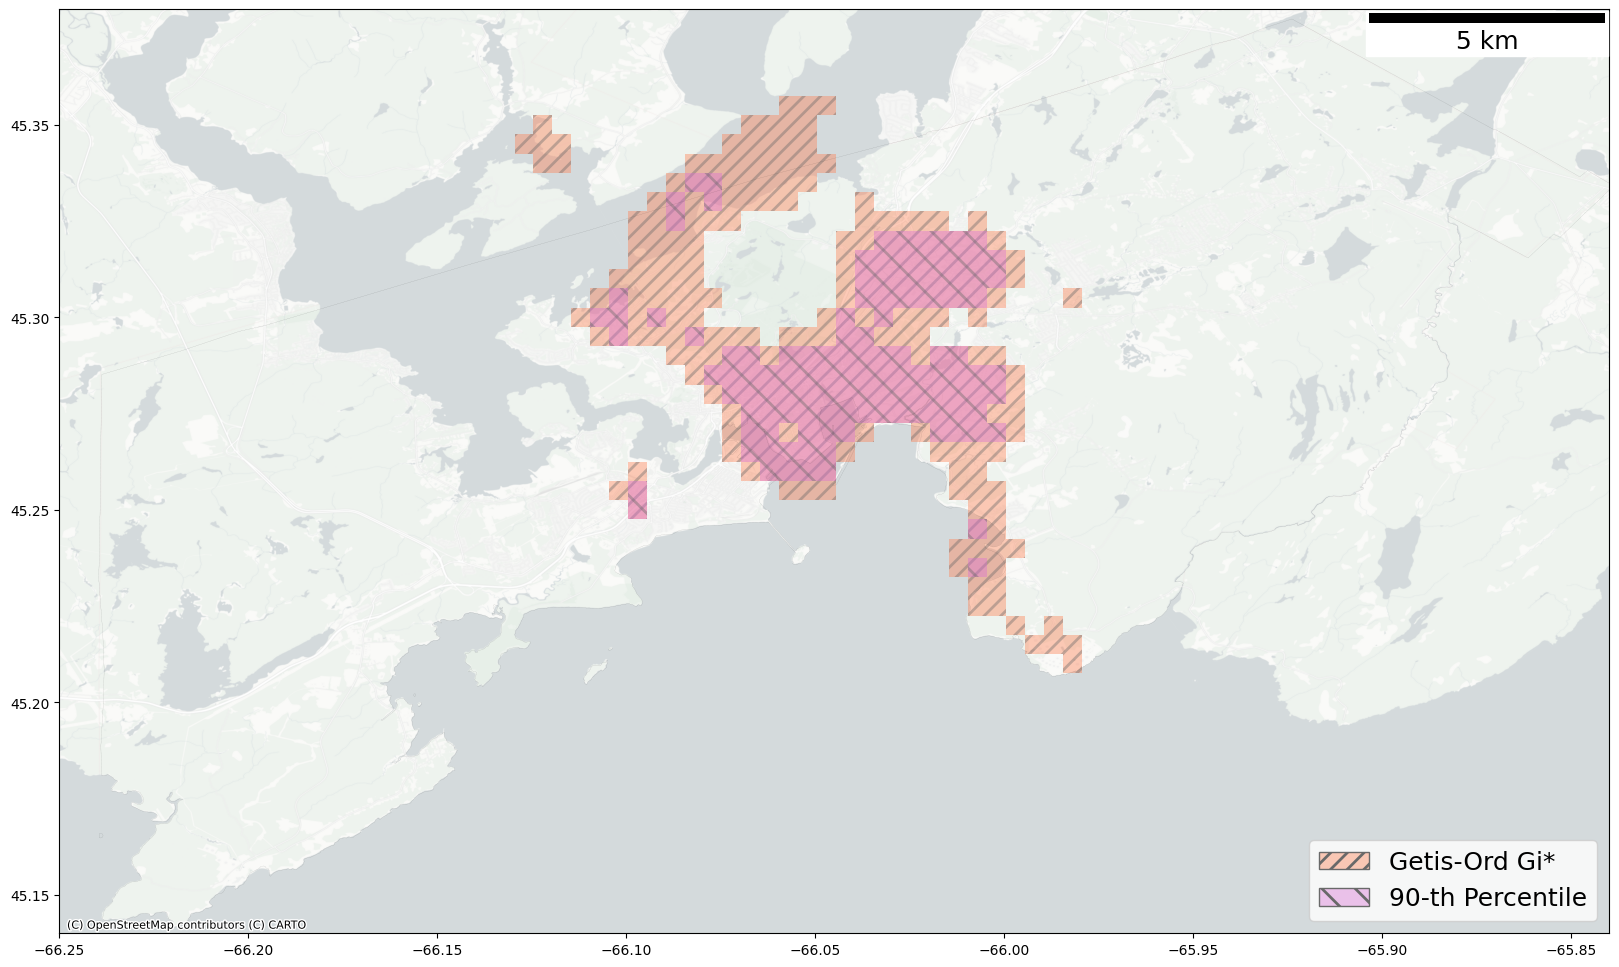

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 2

db1 = gpd.GeoDataFrame(annual_data_2022.reset_index(drop=True), crs="epsg:4326")
db2 = gpd.GeoDataFrame(annual_data_2023.reset_index(drop=True), crs="epsg:4326")
db1.columns = ["id","geometry","mean_so2_2022","max_so2_2022"]
db2.columns = ["id","geometry","mean_so2_2023","max_so2_2023"]
db = db1.merge(db2, on=["id","geometry"], how="left")

# Break observations into significant or not
sig1 = gi_star_2022_mean.p_sim < 0.05
sig2 = gi_star_2023_mean.p_sim < 0.05

# Plot HH clusters
hh1 = db.loc[((gi_star_2022_mean.Zs > 0) & (sig1 == True)) & ((gi_star_2023_mean.Zs > 0) & (sig2 == True)), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="//", label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_decile_1 = np.percentile(db["mean_so2_2022"], 90)
low_decile_1 = np.percentile(db["mean_so2_2022"], 10)
top_decile_2 = np.percentile(db["mean_so2_2023"], 90)
low_decile_2 = np.percentile(db["mean_so2_2023"], 10)
sig1 = (db["mean_so2_2022"] > top_decile_1) | (db["mean_so2_2022"] < low_decile_1)
sig2 = (db["mean_so2_2023"] > top_decile_2) | (db["mean_so2_2023"] < low_decile_2)

# Plot HH clusters
hh2 = db.loc[((db["mean_so2_2022"] > top_decile_1) & (sig1 == True)) & ((db["mean_so2_2023"] > top_decile_2) & (sig2 == True)), "geometry"]
hh2.plot(ax=ax, color="orchid", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="\\", label = "90-th Percentile", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=0.1, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    zoom=14
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}))

## add legend
lines = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor="dimgrey")
    for t in ax.collections[0:-1]
]
labels = [t.get_label() for t in ax.collections[0:-1]]
ax.legend(lines, labels, loc="lower right", prop={'size': 18})

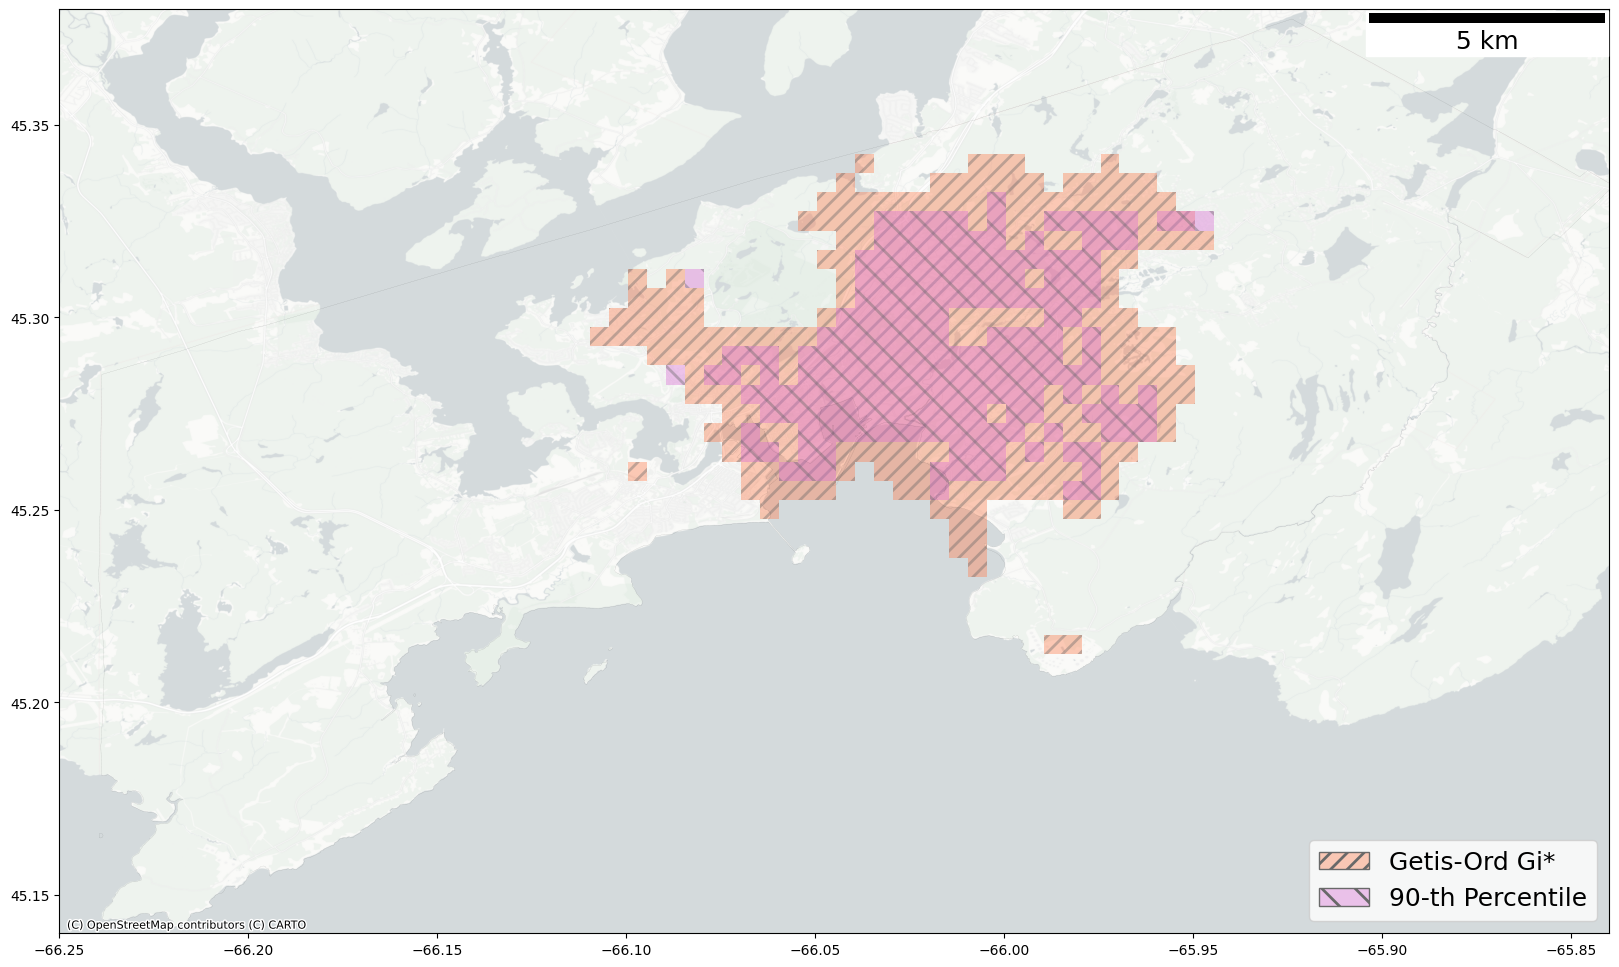

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 2

db1 = gpd.GeoDataFrame(annual_data_2022.reset_index(drop=True), crs="epsg:4326")
db2 = gpd.GeoDataFrame(annual_data_2023.reset_index(drop=True), crs="epsg:4326")
db1.columns = ["id","geometry","mean_so2_2022","max_so2_2022"]
db2.columns = ["id","geometry","mean_so2_2023","max_so2_2023"]
db = db1.merge(db2, on=["id","geometry"], how="left")

# Break observations into significant or not
sig1 = gi_star_2022_max.p_sim < 0.05
sig2 = gi_star_2023_max.p_sim < 0.05

# Plot HH clusters
hh1 = db.loc[((gi_star_2022_max.Zs > 0) & (sig1 == True)) & ((gi_star_2023_max.Zs > 0) & (sig2 == True)), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="//", label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_decile_1 = np.percentile(db["max_so2_2022"], 90)
low_decile_1 = np.percentile(db["max_so2_2022"], 10)
top_decile_2 = np.percentile(db["max_so2_2023"], 90)
low_decile_2 = np.percentile(db["max_so2_2023"], 10)
sig1 = (db["max_so2_2022"] > top_decile_1) | (db["max_so2_2022"] < low_decile_1)
sig2 = (db["max_so2_2023"] > top_decile_2) | (db["max_so2_2023"] < low_decile_2)

# Plot HH clusters
hh2 = db.loc[((db["max_so2_2022"] > top_decile_1) & (sig1 == True)) & ((db["max_so2_2023"] > top_decile_2) & (sig2 == True)), "geometry"]
hh2.plot(ax=ax, color="orchid", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="\\", label = "90-th Percentile", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=0.1, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    zoom=14
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}))

## add legend
lines = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor="dimgrey")
    for t in ax.collections[0:-1]
]
labels = [t.get_label() for t in ax.collections[0:-1]]
ax.legend(lines, labels, loc="lower right", prop={'size': 18})

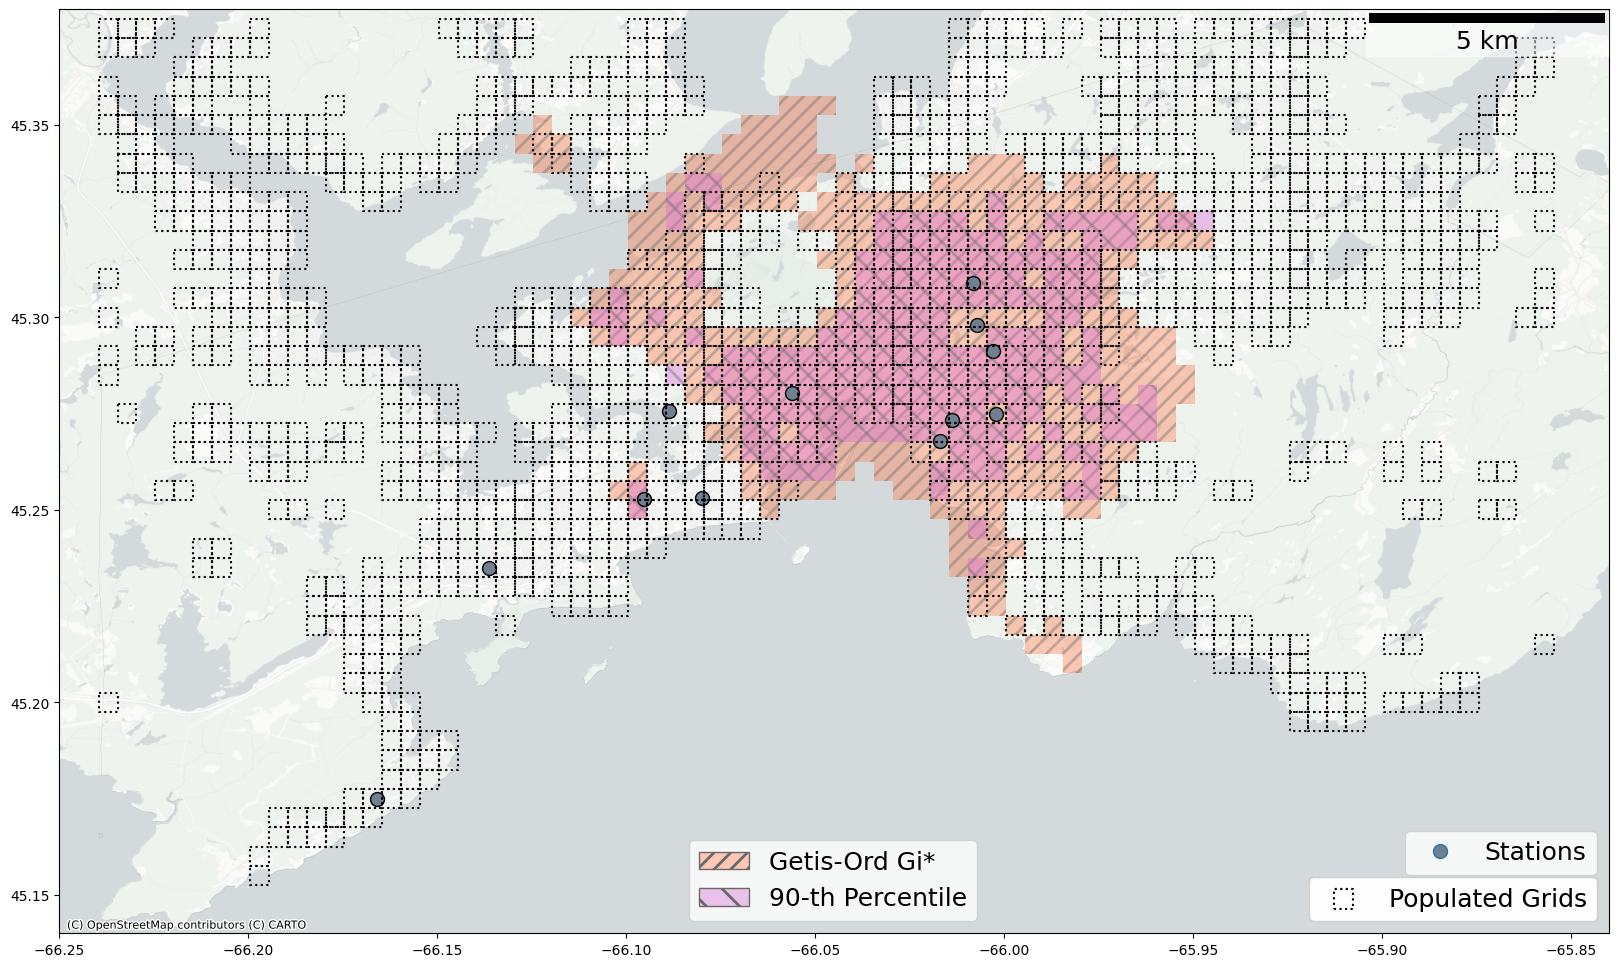

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 2

db1 = gpd.GeoDataFrame(annual_data_2022.reset_index(drop=True), crs="epsg:4326")
db2 = gpd.GeoDataFrame(annual_data_2023.reset_index(drop=True), crs="epsg:4326")
db1.columns = ["id","geometry","mean_so2_2022","max_so2_2022"]
db2.columns = ["id","geometry","mean_so2_2023","max_so2_2023"]
db = db1.merge(db2, on=["id","geometry"], how="left")

# Break observations into significant or not
sig1a = gi_star_2022_mean.p_sim < 0.05
sig2a = gi_star_2023_mean.p_sim < 0.05
sig1b = gi_star_2022_max.p_sim < 0.05
sig2b = gi_star_2023_max.p_sim < 0.05

# Plot HH clusters
hh1 = db.loc[(((gi_star_2022_mean.Zs > 0) & (sig1a == True)) &
             ((gi_star_2023_mean.Zs > 0) & (sig2a == True))) |
             (((gi_star_2022_max.Zs > 0) & (sig1b == True)) &
             ((gi_star_2023_max.Zs > 0) & (sig2b == True))), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="//", label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_decile_1a = np.percentile(db["mean_so2_2022"], 90)
low_decile_1a = np.percentile(db["mean_so2_2022"], 10)
top_decile_2a = np.percentile(db["mean_so2_2023"], 90)
low_decile_2a = np.percentile(db["mean_so2_2023"], 10)
sig1a = (db["mean_so2_2022"] > top_decile_1a) | (db["mean_so2_2022"] < low_decile_1a)
sig2a = (db["mean_so2_2023"] > top_decile_2a) | (db["mean_so2_2023"] < low_decile_2a)

top_decile_1b = np.percentile(db["max_so2_2022"], 90)
low_decile_1b = np.percentile(db["max_so2_2022"], 10)
top_decile_2b = np.percentile(db["max_so2_2023"], 90)
low_decile_2b = np.percentile(db["max_so2_2023"], 10)
sig1b = (db["max_so2_2022"] > top_decile_1b) | (db["max_so2_2022"] < low_decile_1b)
sig2b = (db["max_so2_2023"] > top_decile_2b) | (db["max_so2_2023"] < low_decile_2b)

# Plot HH clusters
hh2 = db.loc[(((db["mean_so2_2022"] > top_decile_1a) & (sig1a == True)) &
              ((db["mean_so2_2023"] > top_decile_2a) & (sig2a == True))) |
             (((db["max_so2_2022"] > top_decile_1b) & (sig1b == True)) &
              ((db["max_so2_2023"] > top_decile_2b) & (sig2b == True))), "geometry"]
hh2.plot(ax=ax, color="orchid", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="\\", label = "90-th Percentile", aspect=None)

# add Saint John

nb_stations.plot(ax=ax, color="slategrey", markersize=100, edgecolor='black', linewidth=1, label="Stations", aspect=None)

urban.plot(ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=1.5, label="Populated Grids", aspect=None)

gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=0.1, aspect=None)


# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    zoom=14
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}, box_alpha=0.5))

## add legend
lines1 = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor="dimgrey")
    for t in ax.collections[0:2]
]
labels1 = [t.get_label() for t in ax.collections[0:2]]
legend1 = ax.legend(lines1, labels1, bbox_to_anchor=(0.6,0), loc="lower right", prop={'size': 18})

lines2 = [
    Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=t.get_facecolor())
    for t in ax.collections[2:3]
]
labels2 = [t.get_label() for t in ax.collections[2:3]]
legend2 = ax.legend(lines2, labels2, bbox_to_anchor=(1,0.05), loc="lower right", prop={'size': 18})

lines3 = [
    plt.scatter([0], [0], linestyle="dotted", marker="s", s=200, facecolors="none", edgecolors='black', linewidth=1.5)
    for t in ax.collections[3:4]
]
labels3 = [t.get_label() for t in ax.collections[3:4]]
legend3 = ax.legend(lines3, labels3, bbox_to_anchor=(1,0), loc="lower right", prop={'size': 18})

ax.add_artist(legend1)
ax.add_artist(legend2)
ax.add_artist(legend3)

In [ ]:
db1 = gpd.GeoDataFrame(annual_data_2022.reset_index(drop=True), crs="epsg:4326")
db2 = gpd.GeoDataFrame(annual_data_2023.reset_index(drop=True), crs="epsg:4326")
db1.columns = ["id","geometry","mean_so2_2022","max_so2_2022"]
db2.columns = ["id","geometry","mean_so2_2023","max_so2_2023"]
db = db1.merge(db2, on=["id","geometry"], how="left")

sig1a = gi_star_2022_mean.p_sim < 0.05
sig2a = gi_star_2023_mean.p_sim < 0.05
sig1b = gi_star_2022_max.p_sim < 0.05
sig2b = gi_star_2023_max.p_sim < 0.05


hh1 = db.loc[(((gi_star_2022_mean.Zs > 0) & (sig1a == True)) &
             ((gi_star_2023_mean.Zs > 0) & (sig2a == True))) |
             (((gi_star_2022_max.Zs > 0) & (sig1b == True)) &
             ((gi_star_2023_max.Zs > 0) & (sig2b == True)))]


top_decile_1a = np.percentile(db["mean_so2_2022"], 90)
low_decile_1a = np.percentile(db["mean_so2_2022"], 10)
top_decile_2a = np.percentile(db["mean_so2_2023"], 90)
low_decile_2a = np.percentile(db["mean_so2_2023"], 10)
sig1a = (db["mean_so2_2022"] > top_decile_1a) | (db["mean_so2_2022"] < low_decile_1a)
sig2a = (db["mean_so2_2023"] > top_decile_2a) | (db["mean_so2_2023"] < low_decile_2a)

top_decile_1b = np.percentile(db["max_so2_2022"], 90)
low_decile_1b = np.percentile(db["max_so2_2022"], 10)
top_decile_2b = np.percentile(db["max_so2_2023"], 90)
low_decile_2b = np.percentile(db["max_so2_2023"], 10)
sig1b = (db["max_so2_2022"] > top_decile_1b) | (db["max_so2_2022"] < low_decile_1b)
sig2b = (db["max_so2_2023"] > top_decile_2b) | (db["max_so2_2023"] < low_decile_2b)


hh2 = db.loc[(((db["mean_so2_2022"] > top_decile_1a) & (sig1a == True)) &
              ((db["mean_so2_2023"] > top_decile_2a) & (sig2a == True))) |
              (((db["max_so2_2022"] > top_decile_1b) & (sig1b == True)) &
              ((db["max_so2_2023"] > top_decile_2b) & (sig2b == True)))]


hotspot = pd.concat([hh1, hh2], axis=0).drop_duplicates().reset_index(drop=True)

####  **TROPOMI SO2 Vertical Column Density :**

In [ ]:
so2_vcd = pd.read_pickle(f"/content/drive/MyDrive/TEMPO/Code Resources/Saint John/whole_scene_TROPOMI_SO2_15km.pkl")
so2_vcd['year'] = so2_vcd['time'].apply(lambda x: x.year)

In [ ]:
annual_so2_vcd = so2_vcd.groupby(['id','geometry','year']).agg({"SO2_column_number_density_15km_mean": [np.mean, np.max]}).reset_index()
annual_so2_vcd.columns = ["id","geometry","year","SO2_column_number_density_15km_mean","SO2_column_number_density_15km_max"]

annual_so2_vcd_2022 = annual_so2_vcd[annual_so2_vcd['year'] == 2022]
annual_so2_vcd_2023 = annual_so2_vcd[annual_so2_vcd['year'] == 2023]
annual_so2_vcd_2022 = annual_so2_vcd_2022.drop(['year'], axis=1)
annual_so2_vcd_2023 = annual_so2_vcd_2023.drop(['year'], axis=1)

In [ ]:
# Rook weights
w2022 = weights.Rook.from_dataframe(annual_so2_vcd_2022)
w2023 = weights.Rook.from_dataframe(annual_so2_vcd_2023)

In [ ]:
# Gi* statistic
gi_star_2022_mean = esda.getisord.G_Local(annual_so2_vcd_2022["SO2_column_number_density_15km_mean"], w2022, star=True, transform='R', permutations=1000, seed=123)
gi_star_2023_mean = esda.getisord.G_Local(annual_so2_vcd_2023["SO2_column_number_density_15km_mean"], w2023, star=True, transform='R', permutations=1000, seed=123)
gi_star_2022_max = esda.getisord.G_Local(annual_so2_vcd_2022["SO2_column_number_density_15km_max"], w2022, star=True, transform='R', permutations=1000, seed=123)
gi_star_2023_max = esda.getisord.G_Local(annual_so2_vcd_2023["SO2_column_number_density_15km_max"], w2023, star=True, transform='R', permutations=1000, seed=123)

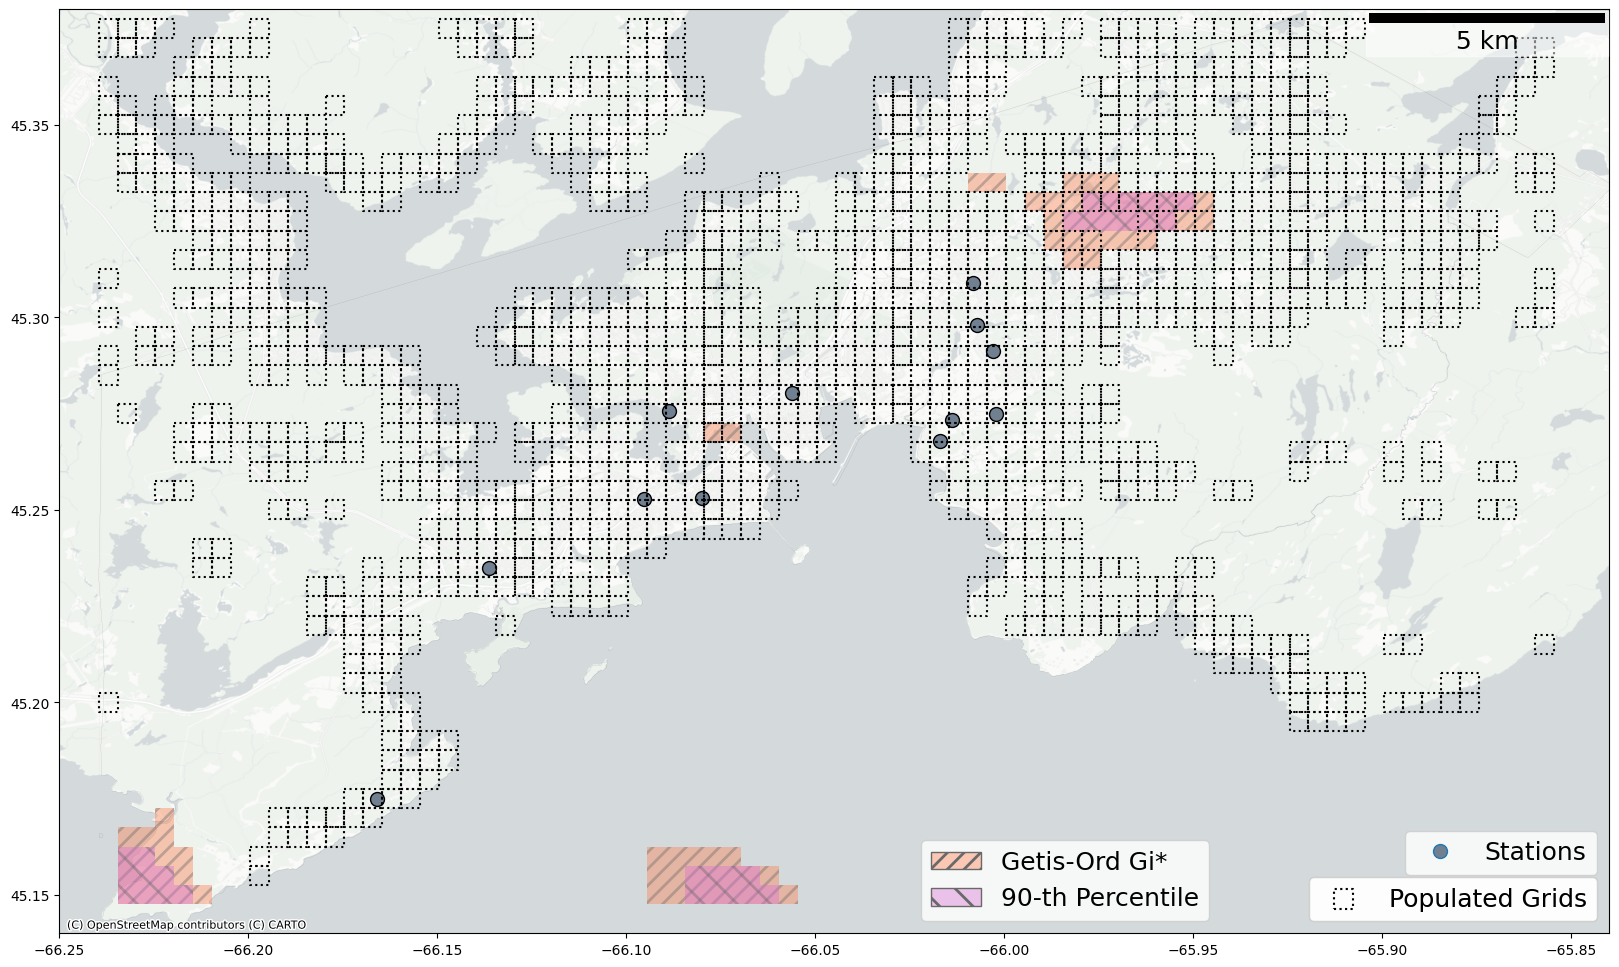

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 2

db1 = gpd.GeoDataFrame(annual_so2_vcd_2022.reset_index(drop=True), crs="epsg:4326")
db2 = gpd.GeoDataFrame(annual_so2_vcd_2023.reset_index(drop=True), crs="epsg:4326")
db1.columns = ["id","geometry","SO2_column_number_density_15km_mean_2022","SO2_column_number_density_15km_max_2022"]
db2.columns = ["id","geometry","SO2_column_number_density_15km_mean_2023","SO2_column_number_density_15km_max_2023"]
db = db1.merge(db2, on=["id","geometry"], how="left")

# Break observations into significant or not
sig1 = gi_star_2022_mean.p_sim < 0.05
sig2 = gi_star_2023_mean.p_sim < 0.05

# Plot HH clusters
hh1 = db.loc[((gi_star_2022_mean.Zs > 0) & (sig1 == True)) & ((gi_star_2023_mean.Zs > 0) & (sig2 == True)), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="//", label = "Getis-Ord Gi*", aspect=None)

# Break observations into significant or not
top_decile_1 = np.percentile(db["SO2_column_number_density_15km_mean_2022"], 90)
low_decile_1 = np.percentile(db["SO2_column_number_density_15km_mean_2022"], 10)
top_decile_2 = np.percentile(db["SO2_column_number_density_15km_mean_2023"], 90)
low_decile_2 = np.percentile(db["SO2_column_number_density_15km_mean_2023"], 10)
sig1 = (db["SO2_column_number_density_15km_mean_2022"] > top_decile_1) | (db["SO2_column_number_density_15km_mean_2022"] < low_decile_1)
sig2 = (db["SO2_column_number_density_15km_mean_2023"] > top_decile_2) | (db["SO2_column_number_density_15km_mean_2023"] < low_decile_2)

# Plot HH clusters
hh2 = db.loc[((db["SO2_column_number_density_15km_mean_2022"] > top_decile_1) & (sig1 == True)) & ((db["SO2_column_number_density_15km_mean_2023"] > top_decile_2) & (sig2 == True)), "geometry"]
hh2.plot(ax=ax, color="orchid", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="\\", label = "90-th Percentile", aspect=None)

# add Saint John

nb_stations.plot(ax=ax, color="slategrey", markersize=100, edgecolor='black', linewidth=1, label="Stations", aspect=None)

urban.plot(ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=1.5, label="Populated Grids", aspect=None)

gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=0.1, aspect=None)


# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    zoom=14
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}, box_alpha=0.5))

## add legend
lines1 = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor="dimgrey")
    for t in ax.collections[0:2]
]
labels1 = [t.get_label() for t in ax.collections[0:2]]
legend1 = ax.legend(lines1, labels1, bbox_to_anchor=(0.75,0), loc="lower right", prop={'size': 18})

lines2 = [
    Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=t.get_facecolor())
    for t in ax.collections[2:3]
]
labels2 = [t.get_label() for t in ax.collections[2:3]]
legend2 = ax.legend(lines2, labels2, bbox_to_anchor=(1,0.05), loc="lower right", prop={'size': 18})

lines3 = [
    plt.scatter([0], [0], linestyle="dotted", marker="s", s=200, facecolors="none", edgecolors='black', linewidth=1.5)
    for t in ax.collections[3:4]
]
labels3 = [t.get_label() for t in ax.collections[3:4]]
legend3 = ax.legend(lines3, labels3, bbox_to_anchor=(1,0), loc="lower right", prop={'size': 18})

ax.add_artist(legend1)
ax.add_artist(legend2)
ax.add_artist(legend3)

####  **Sensitivity Analysis :  extracting a week in 2022 with most Exceedances**

In [ ]:
##  load outcome data
nb_records_path = f"/content/drive/MyDrive/TEMPO/Code Resources/Saint John/intermediate_output/"
nb_so2_files = [x for x in os.listdir(nb_records_path) if "NB FEM SO2" in x]

nb_so2_records = []

for s in range(len(nb_so2_files)):
    nb_station_records = pd.read_excel(nb_records_path + nb_so2_files[s])
    nb_station_records = nb_station_records.iloc[0:-1,:]

    nb_map_stations = list(nb_station_records.columns)[1:]
    nb_map_stations = [x for x in nb_map_stations if x != "Colson Cove - Musquash"]
    nb_map_stations = [x.replace("–", "-").replace(" - IOL", "") for x in nb_map_stations]

    nb_stations_tem = nb_stations[(nb_stations['city'] + " - " + nb_stations['station_name']).isin(nb_map_stations) &
                                  (nb_stations['measurements'] == "SO2")]
    nb_stations_tem = nb_stations_tem[~((nb_stations_tem['station_name'] == "Forest Hills") & (nb_stations_tem['owner'] == "Government of New Brunswick"))]

    nb_stations_tem['geometry'] = list(zip(nb_stations_tem['longitude'], nb_stations_tem['latitude']))
    nb_stations_tem['geometry'] = nb_stations_tem['geometry'].apply(Point)
    nb_stations_tem = gpd.GeoDataFrame(nb_stations_tem, geometry='geometry', crs = 'epsg:4326')

    nb_so2_records.append(nb_station_records)

nb_so2_records = pd.concat(nb_so2_records)
nb_so2_records = nb_so2_records.drop(["Colson Cove - Musquash"], axis=1)
nb_so2_records.columns = ["Result_Date"] + nb_map_stations

In [ ]:
##  pre-process
nb_so2_records = pd.melt(nb_so2_records, id_vars=["Result_Date"])
nb_so2_records.columns = ['time','station_name','so2']
nb_so2_records['station_name'] = nb_so2_records['station_name'].apply(lambda x: x.replace("Saint John - ", "").replace("Colson Cove - ", ""))
nb_so2_records['day_time'] = nb_so2_records['time'].apply(lambda x: x.date())
nb_so2_records = nb_so2_records.sort_values(by=['station_name','time']).reset_index(drop=True)

##  create and obtain lags
for lag in range(24+48):
    nb_so2_records["so2_1hr_lag_" + str(lag+1)] = nb_so2_records.groupby(["station_name"])["so2"].shift(lag)

nb_so2_records['so2_4hr_lag_mean'] = nb_so2_records[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+5)]].mean(axis=1)
nb_so2_records['so2_8hr_lag_mean'] = nb_so2_records[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+9)]].mean(axis=1)
nb_so2_records['so2_12hr_lag_mean'] = nb_so2_records[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+13)]].mean(axis=1)
nb_so2_records['so2_24hr_lag_mean'] = nb_so2_records[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+25)]].mean(axis=1)
nb_so2_records['so2_48hr_lag_mean'] = nb_so2_records[["so2_1hr_lag_" + str(x) for x in range(24+1, 24+49)]].mean(axis=1)

##  create daily aggregates for actual 10-station SO2 measurements
nb_so2_records_agg = nb_so2_records.groupby(['station_name','day_time']).agg({"so2": [np.nanmean, np.nanmax],
                                                                              'so2_4hr_lag_mean': [np.nanmean, np.nanmax],
                                                                              'so2_8hr_lag_mean': [np.nanmean, np.nanmax],
                                                                              'so2_12hr_lag_mean': [np.nanmean, np.nanmax],
                                                                              'so2_24hr_lag_mean': [np.nanmean, np.nanmax],
                                                                              'so2_48hr_lag_mean': [np.nanmean, np.nanmax]}).reset_index()
nb_so2_records_agg.columns = ['station_name','day_time','mean_so2','max_so2',
                              'mean_so2_4hr','max_so2_4hr','mean_so2_8hr','max_so2_8hr',
                              'mean_so2_12hr','max_so2_12hr','mean_so2_24hr','max_so2_24hr',
                              'mean_so2_48hr','max_so2_48hr']
nb_so2_records_agg = nb_so2_records_agg[nb_so2_records_agg['day_time'] != datetime.datetime.date(datetime.datetime.strptime('2024-01-01', "%Y-%m-%d"))]
nb_so2_records_agg = nb_so2_records_agg[nb_so2_records_agg['day_time'] >= datetime.datetime.date(datetime.datetime.strptime('2022-01-01', "%Y-%m-%d"))]
nb_so2_records_agg = nb_so2_records_agg.fillna(0)

In [ ]:
def top_quintile(x):
    return np.percentile(x, 90)

def mean_exceedance(x):
    x = x.apply(lambda a: 1 if a > 15 else 0)
    return x.sum() / len(x)

def max_exceedance(x):
    x = x.apply(lambda a: 1 if a > 56.5 else 0)
    return x.sum() / len(x)

def mean_exceedance_days(x):
    x = x.apply(lambda a: 1 if a > 15 else 0)
    return x.sum()

def max_exceedance_days(x):
    x = x.apply(lambda a: 1 if a > 56.5 else 0)
    return x.sum()

def count_gt_zero(x):
  return sum(x > 0)

def percentage_gt_zero(x):
  return sum(x > 0) / len(x)

def average_loc_exceedance_days(x):
  return sum(x) / sum(x > 0) if sum(x > 0) > 0 else 0

def percentage_exceedance_days(x):
  return sum(x) / (len(x) * 365)

In [ ]:
high_data = data[(data['time'] >= datetime.date(2022, 7, 11)) & (data['time'] < datetime.date(2022, 7, 18))] \
              .groupby(['id']) \
              .agg({"mean_so2": [np.mean, top_quintile, mean_exceedance_days],
                    "max_so2": [np.mean, top_quintile, max_exceedance_days]}) \
              .reset_index()

high_data.columns = ["id","mean_so2","mean_so2_top_quin","mean_so2_exceedance","max_so2","max_so2_top_quin","max_so2_exceedance"]
high_data = high_data.merge(data[['id','geometry']].drop_duplicates(), how='left', on=['id'])

In [ ]:
exceedance_stations = pd.concat([nb_so2_records_agg[nb_so2_records_agg['mean_so2'] > 15].sort_values(by=['day_time']),
                                 nb_so2_records_agg[nb_so2_records_agg['max_so2'] > 56.5].sort_values(by=['day_time'])])
exceedance_stations = exceedance_stations[(exceedance_stations['day_time'] >= datetime.date(2022, 7, 11)) &
                                          (exceedance_stations['day_time'] < datetime.date(2022, 7, 18))]
exceedance_stations = nb_stations[nb_stations['station_name'].isin(exceedance_stations['station_name'])]

In [ ]:
# Rook weights
w_high = weights.Rook.from_dataframe(high_data)
# Gi* statistic
gi_star_high_mean = esda.getisord.G_Local(high_data["mean_so2"], w_high , star=True, transform='R', permutations=1000, seed=123)
gi_star_high_max = esda.getisord.G_Local(high_data["max_so2"], w_high , star=True, transform='R', permutations=1000, seed=123)

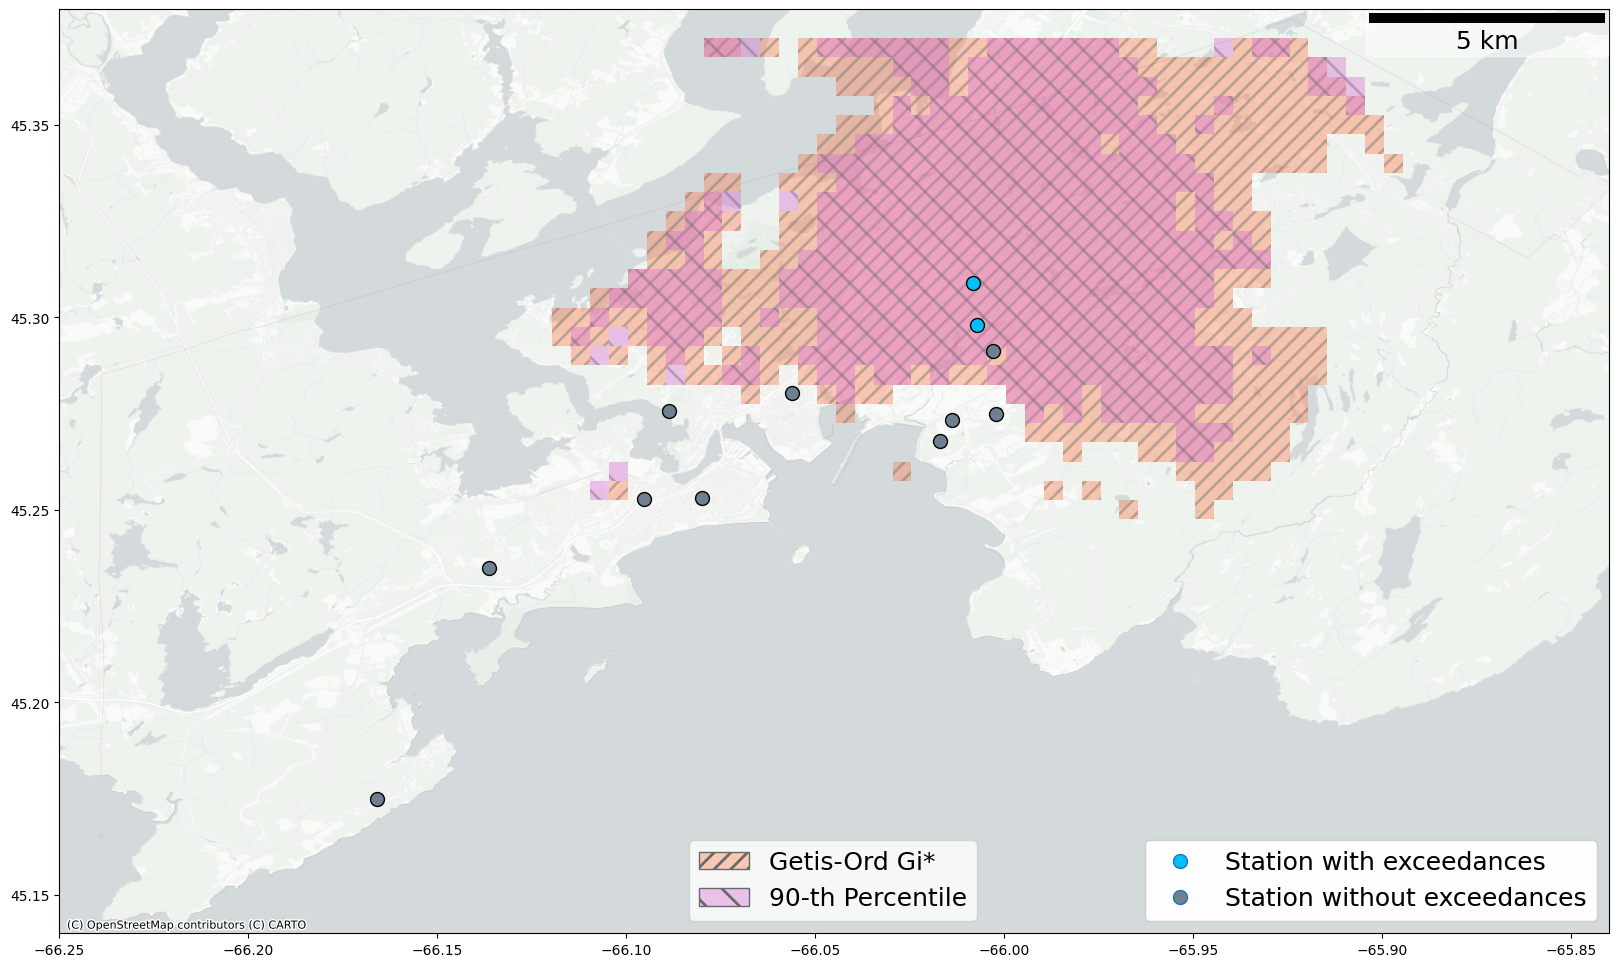

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plt.rcParams['hatch.linewidth'] = 2

db = gpd.GeoDataFrame(high_data, crs="epsg:4326")

# Break observations into significant or not
sig1 = gi_star_high_mean.p_sim < 0.05
sig2 = gi_star_high_max.p_sim < 0.05

# Plot HH clusters
hh1 = db.loc[((gi_star_high_mean.Zs > 0) & (sig1 == True)) |
             ((gi_star_high_max.Zs > 0) & (sig2 == True)), "geometry"]
hh1.plot(ax=ax, color="coral", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="//", label = "Getis-Ord Gi*", aspect=None)


# Break observations into significant or not
top_decile_1 = np.percentile(db["mean_so2"], 90)
low_decile_1 = np.percentile(db["mean_so2"], 10)
sig1 = (db["mean_so2"] > top_decile_1) | (db["mean_so2"] < low_decile_1)

top_decile_2 = np.percentile(db["max_so2"], 90)
low_decile_2 = np.percentile(db["max_so2"], 10)
sig2 = (db["max_so2"] > top_decile_2) | (db["max_so2"] < low_decile_2)

# Plot HH clusters
hh2 = db.loc[((db["mean_so2"] > top_decile_1) & (sig1 == True)) |
             ((db["max_so2"] > top_decile_2) & (sig2 == True)), "geometry"]
hh2.plot(ax=ax, color="orchid", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="\\", label = "90-th Percentile", aspect=None)

# add station locations with / without exceedance
exceedance_stations.plot(ax=ax, color="deepskyblue", markersize=100, edgecolor='black', linewidth=1, label="Station with exceedances", aspect=None)
nb_stations[~nb_stations['station_name'].isin(exceedance_stations['station_name'])].plot(ax=ax, color="slategrey", markersize=100, edgecolor='black', linewidth=1, label="Station without exceedances", aspect=None)

# add Saint John
gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=0.1, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    zoom=14
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}, box_alpha=0.5))

## add legend
lines1 = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor="dimgrey")
    for t in ax.collections[0:-3]
]
labels1 = [t.get_label() for t in ax.collections[0:-3]]
legend1 = ax.legend(lines1, labels1, bbox_to_anchor=(0.6,0), loc="lower right", prop={'size': 18})

lines2 = [
    Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=t.get_facecolor())
    for t in ax.collections[-3:-1]
]
labels2 = [t.get_label() for t in ax.collections[-3:-1]]
legend2 = ax.legend(lines2, labels2, bbox_to_anchor=(1,0), loc="lower right", prop={'size': 18})

ax.add_artist(legend1)
ax.add_artist(legend2)

####  **All Exceedance-day HGBM model-derived Daily Mean & Maximum SO2 :**

In [ ]:
high_data = data[(data['time'].isin(nb_so2_records_agg[nb_so2_records_agg['mean_so2']>15].sort_values(by=["day_time"])["day_time"]))] \
              .groupby(['id']) \
              .agg({"mean_so2_transform": [np.mean, top_quintile, mean_exceedance_days], 
                    "max_so2_transform": [np.mean, top_quintile, max_exceedance_days]}) \
              .reset_index()

high_data.columns = ["id","mean_so2","mean_so2_top_quin","mean_so2_exceedance","max_so2","max_so2_top_quin","max_so2_exceedance"]
high_data = high_data.merge(data[['id','geometry']].drop_duplicates(), how='left', on=['id'])

In [ ]:
# Rook weights
w_high = weights.Rook.from_dataframe(high_data)
# Gi* statistic
gi_star_high_mean = esda.getisord.G_Local(high_data["mean_so2"], w_high , star=True, transform='R', permutations=1000, seed=123)
gi_star_high_max = esda.getisord.G_Local(high_data["max_so2"], w_high , star=True, transform='R', permutations=1000, seed=123)

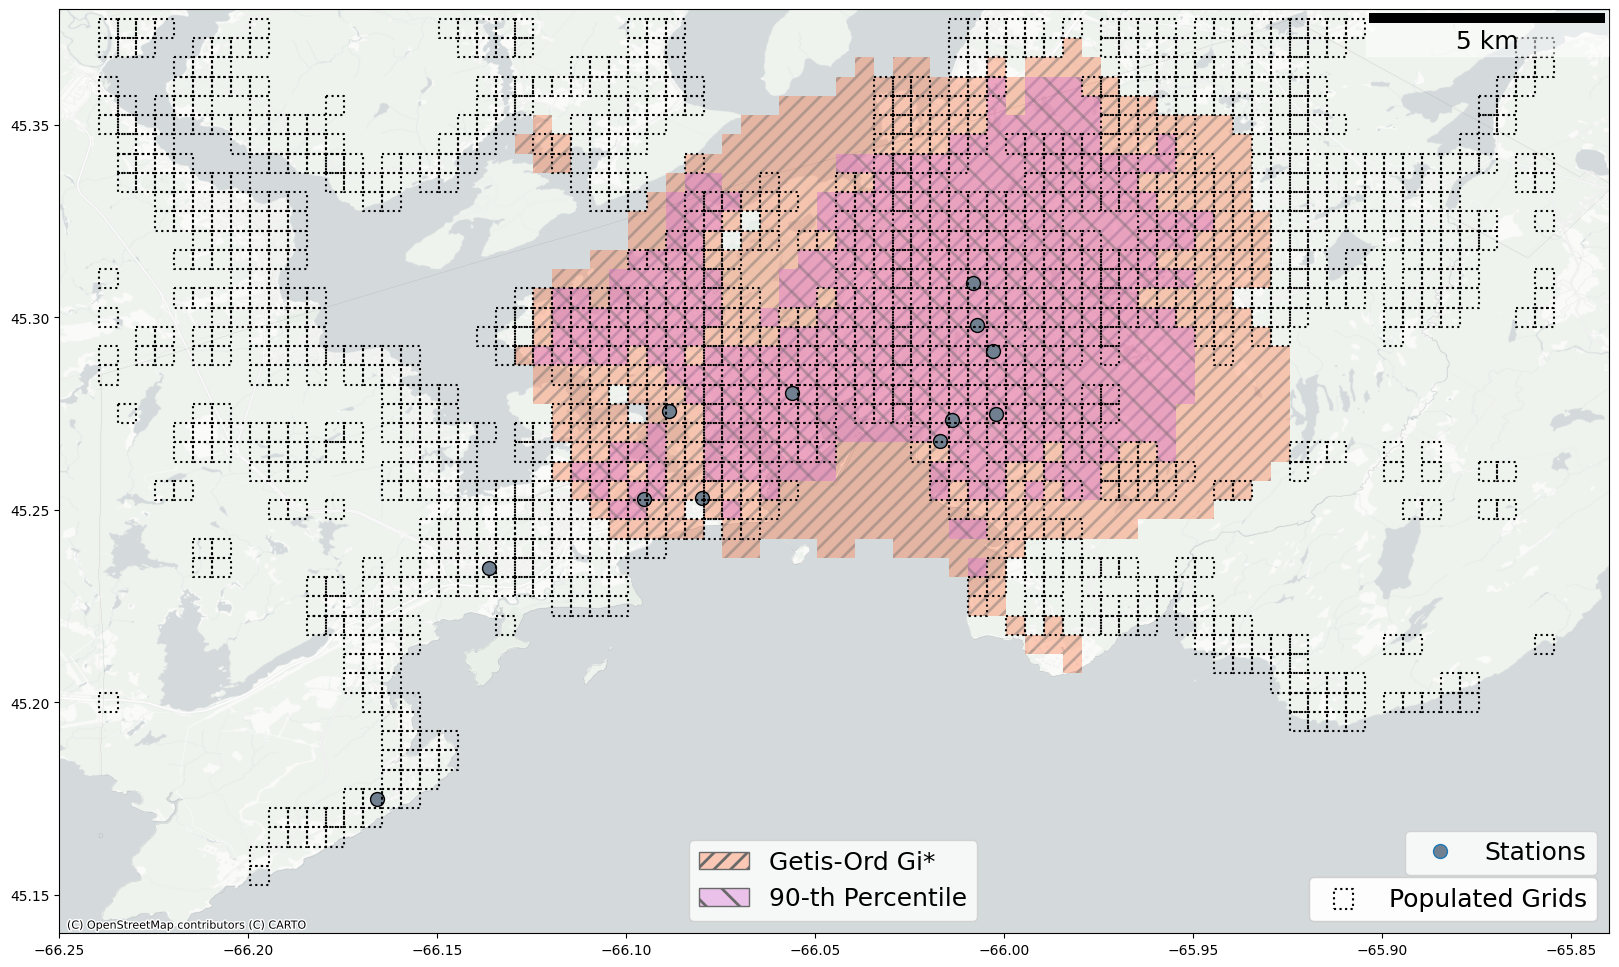

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

gpd.GeoDataFrame(pd.concat([hh1[['id','geometry']], hh1_high[['id','geometry']]], axis=0).drop_duplicates().reset_index(drop=True)).plot(
    ax=ax, color="coral", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="//", label = "Getis-Ord Gi*", aspect=None
)
gpd.GeoDataFrame(pd.concat([hh2[['id','geometry']], hh2_high[['id','geometry']]], axis=0).drop_duplicates().reset_index(drop=True)).plot(
    ax=ax, color="orchid", edgecolor="dimgrey", linewidth=0, alpha=0.4, facecolor="none", hatch="\\", label = "90-th Percentile", aspect=None
)

nb_stations.plot(ax=ax, color="slategrey", markersize=100, edgecolor='black', linewidth=1, label="Stations", aspect=None)

urban.plot(ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=1.5, label="Populated Grids", aspect=None)

gpd.GeoDataFrame(csd_sj_geom_gjs).plot(ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=0.1, aspect=None)

# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    zoom=14
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 18}, box_alpha=0.5))

## add legend
lines1 = [
    Patch(facecolor=t.get_facecolor(), hatch=t.get_hatch(), edgecolor="dimgrey")
    for t in ax.collections[0:2]
]
labels1 = [t.get_label() for t in ax.collections[0:2]]
legend1 = ax.legend(lines1, labels1, bbox_to_anchor=(0.6,0), loc="lower right", prop={'size': 18})

lines2 = [
    Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=t.get_facecolor())
    for t in ax.collections[2:3]
]
labels2 = [t.get_label() for t in ax.collections[2:3]]
legend2 = ax.legend(lines2, labels2, bbox_to_anchor=(1,0.05), loc="lower right", prop={'size': 18})

lines3 = [
    plt.scatter([0], [0], linestyle="dotted", marker="s", s=200, facecolors="none", edgecolors='black', linewidth=1.5)
    for t in ax.collections[3:4]
]
labels3 = [t.get_label() for t in ax.collections[3:4]]
legend3 = ax.legend(lines3, labels3, bbox_to_anchor=(1,0), loc="lower right", prop={'size': 18})

ax.add_artist(legend1)
ax.add_artist(legend2)
ax.add_artist(legend3)

In [ ]:
db = gpd.GeoDataFrame(high_data, crs="epsg:4326")

sig1 = gi_star_high_mean.p_sim < 0.05
sig2 = gi_star_high_max.p_sim < 0.05

hh1_high = db.loc[((gi_star_high_mean.Zs > 0) & (sig1 == True)) |
                  ((gi_star_high_max.Zs > 0) & (sig2 == True))]


top_decile_1 = np.percentile(db["mean_so2"], 90)
low_decile_1 = np.percentile(db["mean_so2"], 10)
sig1 = (db["mean_so2"] > top_decile_1) | (db["mean_so2"] < low_decile_1)

top_decile_2 = np.percentile(db["max_so2"], 90)
low_decile_2 = np.percentile(db["max_so2"], 10)
sig2 = (db["max_so2"] > top_decile_2) | (db["max_so2"] < low_decile_2)

hh2_high = db.loc[((db["mean_so2"] > top_decile_1) & (sig1 == True)) |
                  ((db["max_so2"] > top_decile_2) & (sig2 == True))]


exceedance_days_hotspot = pd.concat([hh1_high, hh2_high], axis=0).drop_duplicates().reset_index(drop=True)

#### **Detection of Monitoring Gaps (under-monitored areas) :**

In [ ]:
###  call new brunswick air quality monitoring station data
nb_stations = pd.read_excel(f"/content/drive/MyDrive/TEMPO/Air Quality Data/NB_Air_Quality_stations_metadata.xlsx")

nb_stations = nb_stations[(nb_stations['city'].isin(['Saint John','Colson Cove'])) & (nb_stations['measurements'].isin(["SO2","TRS"]))]
nb_stations = nb_stations[~((nb_stations['station_name'] == "Forest Hills") & (nb_stations['owner'] == "Government of New Brunswick"))]
nb_stations = nb_stations[nb_stations['station_name'] != "Musquash"]
nb_stations = nb_stations[nb_stations['station_name'] != "Saint John Street"]

nb_stations['geometry'] = list(zip(nb_stations['longitude'], nb_stations['latitude']))
nb_stations['geometry'] = nb_stations['geometry'].apply(Point)
nb_stations = gpd.GeoDataFrame(nb_stations, geometry='geometry', crs = 'epsg:4326')

In [ ]:
#  get pairwise distance between all stations (including the stations measuring only TRS)
matrix = nb_stations.geometry.apply(lambda g: nb_stations.geometry.distance(g))
matrix[matrix == 0] = np.nan

In [ ]:
#  get pairwise distance between stations (excluding the stations measuring only TRS)
matrix2 = nb_stations[~nb_stations['station_name'].isin(['Bridge Street','Sherbrook St.','Milford'])].geometry.apply(
    lambda g: nb_stations[~nb_stations['station_name'].isin(['Bridge Street','Sherbrook St.','Milford'])].geometry.distance(g)
    )
matrix2[matrix2 == 0] = np.nan

In [ ]:
#  evaluate each grid its need for additional monitoring (including the stations measuring only TRS in grid-station proximity calculations)

grid_eval = []

for g in range(urban.shape[0]):

    grid_point = urban.geometry.centroid.iloc[g]

    getis_hh = gpd.GeoDataFrame(pd.concat([hh1[['id','geometry']], hh1_high[['id','geometry']]], axis=0)).reset_index(drop=True)
    decile_hh = gpd.GeoDataFrame(pd.concat([hh2[['id','geometry']], hh2_high[['id','geometry']]], axis=0)).reset_index(drop=True)

    vicinity_getis = np.min(getis_hh.centroid.distance(grid_point))
    vicinity_decile = np.min(decile_hh.centroid.distance(grid_point))
    vicinity_station = np.min(nb_stations.distance(grid_point))

    grid_info = pd.DataFrame({
        "id": urban.id.iloc[g],
        "vicinity Getis-Ord Gi* hotspot": vicinity_getis,
        "vicinity 90th Decile hotspot": vicinity_decile,
        "vicinity Station": vicinity_station,
    }, index=[0])

    grid_eval.append(grid_info)

grid_eval = pd.concat(grid_eval).reset_index(drop=True)

grid_eval = grid_eval.merge(urban, on=['id'], how='left')

In [ ]:
#  evaluate each grid its need for additional monitoring (excluding the stations measuring only TRS in grid-station proximity calculations)

grid_eval_sensitive = []

for g in range(urban.shape[0]):

    grid_point = urban.geometry.centroid.iloc[g]

    getis_hh = gpd.GeoDataFrame(pd.concat([hh1[['id','geometry']], hh1_high[['id','geometry']]], axis=0)).reset_index(drop=True)
    decile_hh = gpd.GeoDataFrame(pd.concat([hh2[['id','geometry']], hh2_high[['id','geometry']]], axis=0)).reset_index(drop=True)

    vicinity_getis = np.min(getis_hh.centroid.distance(grid_point))
    vicinity_decile = np.min(decile_hh.centroid.distance(grid_point))
    vicinity_station = np.min(nb_stations[~nb_stations['station_name'].isin(['Bridge Street','Sherbrook St.','Milford'])].distance(grid_point))

    grid_info = pd.DataFrame({
        "id": urban.id.iloc[g],
        "vicinity Getis-Ord Gi* hotspot": vicinity_getis,
        "vicinity 90th Decile hotspot": vicinity_decile,
        "vicinity Station": vicinity_station,
    }, index=[0])

    grid_eval_sensitive.append(grid_info)

grid_eval_sensitive = pd.concat(grid_eval_sensitive).reset_index(drop=True)

grid_eval_sensitive = grid_eval_sensitive.merge(urban, on=['id'], how='left')

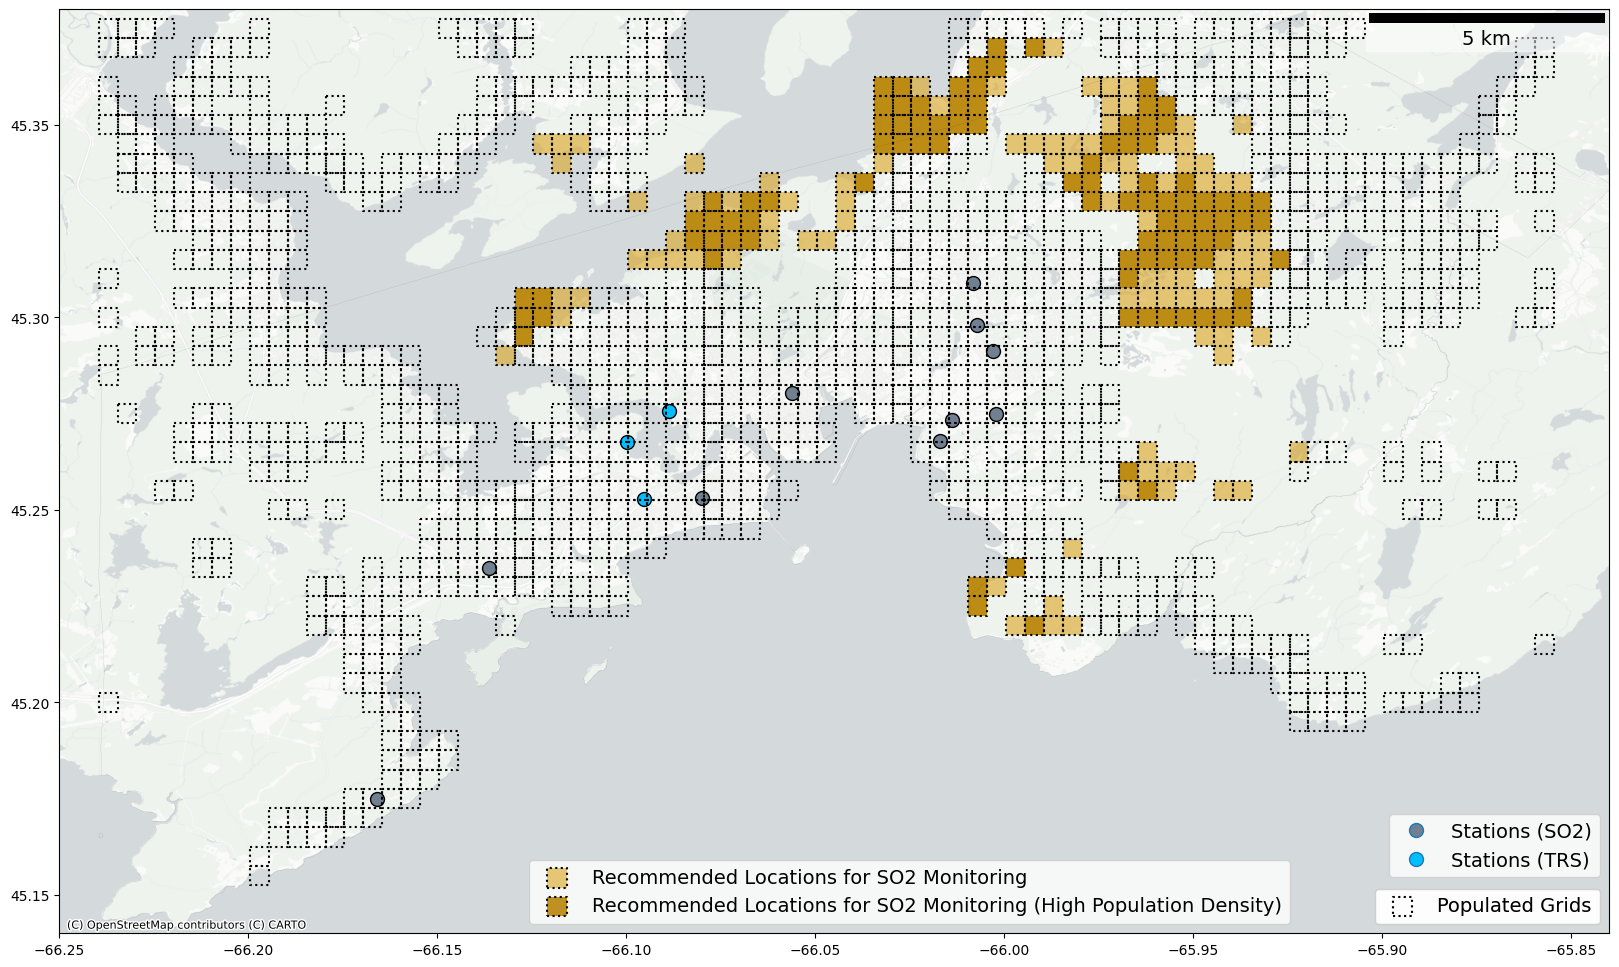

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

gpd.GeoDataFrame(
  grid_eval[((grid_eval["vicinity Getis-Ord Gi* hotspot"] < 0.005) |
             (grid_eval["vicinity 90th Decile hotspot"] < 0.01)) &
             (grid_eval["vicinity Station"] >= round(np.nanpercentile(matrix / 2, 50), 4))
]).plot(
    ax=ax, color="goldenrod", edgecolor="dimgrey", linewidth=0, alpha=0.6, facecolor="none", 
    label = "Recommended Locations for SO2 Monitoring", aspect=None
)

gpd.GeoDataFrame(
  grid_eval[((grid_eval["vicinity Getis-Ord Gi* hotspot"] < 0.005) |
             (grid_eval["vicinity 90th Decile hotspot"] < 0.01)) &
             (grid_eval["vicinity Station"] >= round(np.nanpercentile(matrix / 2, 50), 4)) &
             (grid_eval["pop_den_mean"] >= np.percentile(grid_eval["pop_den_mean"], 50))
]).plot(
    ax=ax, color="darkgoldenrod", edgecolor="dimgrey", linewidth=0, alpha=0.9, facecolor="none", 
    label = "Recommended Locations for SO2 Monitoring (High Population Density)", aspect=None
)

nb_stations[~nb_stations['station_name'].isin(['Bridge Street','Sherbrook St.','Milford'])].plot(
    ax=ax, color="slategrey", markersize=100, edgecolor='black', linewidth=1, 
    label="Stations (SO2)", aspect=None
)
nb_stations[nb_stations['station_name'].isin(['Bridge Street','Sherbrook St.','Milford'])].plot(
    ax=ax, color="deepskyblue", markersize=100, edgecolor='black', linewidth=1, 
    label="Stations (TRS)", aspect=None
)

urban.plot(
    ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=1.5, 
    label="Populated Grids", aspect=None
)

gpd.GeoDataFrame(csd_sj_geom_gjs).plot(
    ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=0.1, aspect=None
)


# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    zoom=14
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 14}, box_alpha=0.5))

## add legend
lines1 = [
    plt.scatter([0], [0], linestyle="dotted", marker="s", s=200, facecolors=t.get_facecolor(), edgecolors='black', linewidth=1.5)
    for t in ax.collections[0:2]
]
labels1 = [t.get_label() for t in ax.collections[0:2]]
legend1 = ax.legend(lines1, labels1, bbox_to_anchor=(0.8,0), loc="lower right", prop={'size': 14})

lines2 = [
    Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=t.get_facecolor())
    for t in ax.collections[2:4]
]
labels2 = [t.get_label() for t in ax.collections[2:4]]
legend2 = ax.legend(lines2, labels2, bbox_to_anchor=(1,0.05), loc="lower right", prop={'size': 14})

lines3 = [
    plt.scatter([0], [0], linestyle="dotted", marker="s", s=200, facecolors="none", edgecolors='black', linewidth=1.5)
    for t in ax.collections[4:5]
]
labels3 = [t.get_label() for t in ax.collections[4:5]]
legend3 = ax.legend(lines3, labels3, bbox_to_anchor=(1,0), loc="lower right", prop={'size': 14})

ax.add_artist(legend1)
ax.add_artist(legend2)
ax.add_artist(legend3)

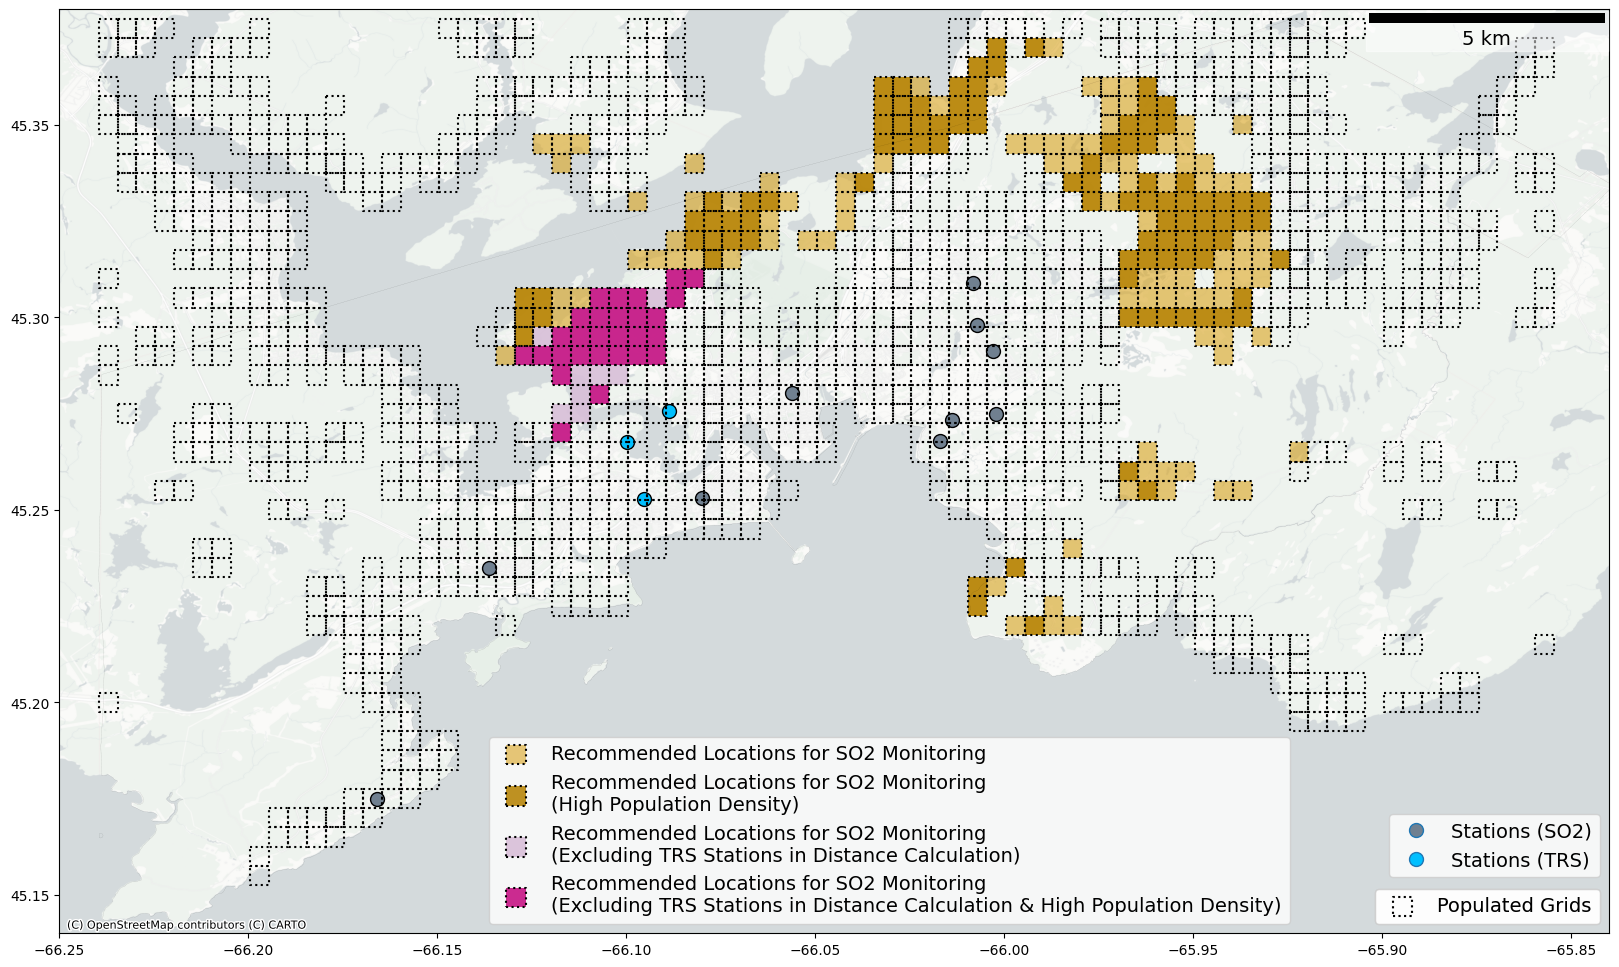

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

gpd.GeoDataFrame(
  grid_eval[((grid_eval["vicinity Getis-Ord Gi* hotspot"] < 0.005) |
             (grid_eval["vicinity 90th Decile hotspot"] < 0.01)) &
             (grid_eval["vicinity Station"] >= round(np.nanpercentile(matrix / 2, 50), 4))
]).plot(
    ax=ax, color="goldenrod", edgecolor="dimgrey", linewidth=0, alpha=0.6, facecolor="none", 
    label = "Recommended Locations for SO2 Monitoring", 
    aspect=None
)

gpd.GeoDataFrame(
  grid_eval[((grid_eval["vicinity Getis-Ord Gi* hotspot"] < 0.005) |
             (grid_eval["vicinity 90th Decile hotspot"] < 0.01)) &
             (grid_eval["vicinity Station"] >= round(np.nanpercentile(matrix / 2, 50), 4)) &
             (grid_eval["pop_den_mean"] >= np.percentile(grid_eval["pop_den_mean"], 50))
]).plot(
    ax=ax, color="darkgoldenrod", edgecolor="dimgrey", linewidth=0, alpha=0.9, facecolor="none", 
    label = "Recommended Locations for SO2 Monitoring \n(High Population Density)", 
    aspect=None
)

grid_eval_tem = grid_eval_sensitive[~grid_eval_sensitive['id'].isin(
                    grid_eval[((grid_eval["vicinity Getis-Ord Gi* hotspot"] < 0.005) |
                              (grid_eval["vicinity 90th Decile hotspot"] < 0.01)) &
                              (grid_eval["vicinity Station"] >= round(np.nanpercentile(matrix / 2, 50), 4))]['id']
                )]

gpd.GeoDataFrame(
  grid_eval_tem[((grid_eval_tem["vicinity Getis-Ord Gi* hotspot"] < 0.005) |
                  (grid_eval_tem["vicinity 90th Decile hotspot"] < 0.01)) &
                  (grid_eval_tem["vicinity Station"] >= round(np.nanpercentile(matrix / 2, 50), 4))
]).plot(
    ax=ax, color="thistle", edgecolor="dimgrey", linewidth=0, alpha=0.9, facecolor="none", 
    label = "Recommended Locations for SO2 Monitoring \n(Excluding TRS Stations in Distance Calculation)", 
    aspect=None
)

gpd.GeoDataFrame(
  grid_eval_tem[((grid_eval_tem["vicinity Getis-Ord Gi* hotspot"] < 0.005) |
                  (grid_eval_tem["vicinity 90th Decile hotspot"] < 0.01)) &
                  (grid_eval_tem["vicinity Station"] >= round(np.nanpercentile(matrix / 2, 50), 4)) &
                  (grid_eval_tem["pop_den_mean"] >= np.percentile(grid_eval["pop_den_mean"], 50))
]).plot(
    ax=ax, color="mediumvioletred", edgecolor="dimgrey", linewidth=0, alpha=0.9, facecolor="none", 
    label = "Recommended Locations for SO2 Monitoring \n(Excluding TRS Stations in Distance Calculation & High Population Density)", 
    aspect=None
)

nb_stations[~nb_stations['station_name'].isin(['Bridge Street','Sherbrook St.','Milford'])].plot(
    ax=ax, color="slategrey", markersize=100, edgecolor='black', linewidth=1, 
    label="Stations (SO2)", aspect=None
)
nb_stations[nb_stations['station_name'].isin(['Bridge Street','Sherbrook St.','Milford'])].plot(
    ax=ax, color="deepskyblue", markersize=100, edgecolor='black', linewidth=1, 
    label="Stations (TRS)", aspect=None
)

urban.plot(
    ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=1.5, 
    label="Populated Grids", aspect=None
)

gpd.GeoDataFrame(csd_sj_geom_gjs).plot(
    ax=ax, linestyles='dotted', facecolor="none", edgecolor='black', linewidth=0.1, aspect=None
)


# basemap
contextily.add_basemap(
    ax=ax,
    crs="epsg:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
    zoom=14
)

ax.set_xlim(-66.250, -65.840)
ax.set_ylim(45.140, 45.380)

##  specify 1 degree of distance for creating a spatial scale bar
points = gpd.GeoSeries(
    [Point(-66.250, 45.140), Point(-65.250, 45.140)], crs=4326
)
points = points.to_crs(3347)
scale_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(scale_meters, font_properties={"size": 14}, box_alpha=0.5))

## add legend
lines1 = [
    plt.scatter([0], [0], linestyle="dotted", marker="s", s=200, facecolors=t.get_facecolor(), edgecolors='black', linewidth=1.5)
    for t in ax.collections[0:4]
]
labels1 = [t.get_label() for t in ax.collections[0:4]]
legend1 = ax.legend(lines1, labels1, bbox_to_anchor=(0.8,0), loc="lower right", prop={'size': 14})

lines2 = [
    Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor=t.get_facecolor())
    for t in ax.collections[4:6]
]
labels2 = [t.get_label() for t in ax.collections[4:6]]
legend2 = ax.legend(lines2, labels2, bbox_to_anchor=(1,0.05), loc="lower right", prop={'size': 14})

lines3 = [
    plt.scatter([0], [0], linestyle="dotted", marker="s", s=200, facecolors="none", edgecolors='black', linewidth=1.5)
    for t in ax.collections[6:7]
]
labels3 = [t.get_label() for t in ax.collections[6:7]]
legend3 = ax.legend(lines3, labels3, bbox_to_anchor=(1,0), loc="lower right", prop={'size': 14})

ax.add_artist(legend1)
ax.add_artist(legend2)
ax.add_artist(legend3)